In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np  # Provides support for large, multi-dimensional arrays and matrices
import pandas as pd  # Offers data structures and tools for data manipulation (like DataFrames)
import matplotlib.pyplot as plt  # Used for data visualization and plotting

# Scikit-learn tools for preprocessing and evaluation metrics
from sklearn.preprocessing import MinMaxScaler  # Normalizes features by scaling them to a given range
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score  # Metrics for evaluating model performance

# TensorFlow and Keras for deep learning model construction and training
import tensorflow as tf  # TensorFlow framework
from tensorflow.keras.models import Model  # Base class for all Keras models
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed  # Core layers for RNNs and seq2seq
from tensorflow.keras.callbacks import EarlyStopping  # Callback to stop training when validation loss doesn't improve

# TensorFlow utility to inspect available hardware
from tensorflow.python.client import device_lib  # Lists physical devices (like GPU/CPU)

import os  # For interacting with the operating system

# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 10  # Number of time steps to use as input to the model
FORECAST_STEPS = 10  # Number of time steps the model will forecast ahead
TEST_RATIO = 0.3  # Proportion of data to use for testing
EPOCHS_LIST = [20]  # Number of training epochs to try
BATCH_SIZES = [64]  # Batch sizes to try for training
WINDOW_SIZE_SIMULATION = 10  # Window size for simulation/anomaly detection
THRESHOLD_PERCENTILE = 90  # Percentile to determine anomaly threshold from reconstruction error
SEED = 42  # Random seed for reproducibility
np.random.seed(SEED)  # Set NumPy random seed
tf.random.set_seed(SEED)  # Set TensorFlow random seed

# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')  # Get list of GPU devices available
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevent TensorFlow from allocating all GPU memory at once
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Set the first GPU as visible to TensorFlow
        print("✅ GPU is available and will be used.")  # Confirm GPU usage
    except RuntimeError as e:
        print(e)  # Print any runtime error during GPU setup
else:
    print("⚠️ No GPU detected, running on CPU.")  # Notify that computation will happen on CPU

# ========================
# 3. LOAD AND PREPROCESS DATA
# ========================
# Load original labeled dataset and parse DateTime column
original_df = pd.read_csv('../../data/test_set.csv')
original_df['DateTime'] = pd.to_datetime(original_df['DateTime'], errors='coerce')
original_df.set_index('DateTime', inplace=True)

# Load cleaned labeled dataset and parse DateTime column
cleaned_df = pd.read_csv('../../data/cleaned_labeled_dataset.csv')
cleaned_df['DateTime'] = pd.to_datetime(cleaned_df['DateTime'], errors='coerce')
cleaned_df.set_index('DateTime', inplace=True)

# Separate out labels for evaluation and remove them from feature data
original_labels = original_df['labels'].copy()
original_df.drop(columns=['labels'], inplace=True)
cleaned_df.drop(columns=['labels'], inplace=True)

# Drop columns with more than 30% missing values and fill the rest
original_df.dropna(axis=1, thresh=int(0.7 * len(original_df)), inplace=True)
original_df.ffill(inplace=True)  # Forward fill
original_df.bfill(inplace=True)  # Backward fill

cleaned_df.dropna(axis=1, thresh=int(0.7 * len(cleaned_df)), inplace=True)
cleaned_df.ffill(inplace=True)
cleaned_df.bfill(inplace=True)

# Normalize data using MinMaxScaler to scale features to [0, 1]
scaler = MinMaxScaler()
original_scaled = scaler.fit_transform(original_df.values)  # Fit on original data
cleaned_scaled = scaler.transform(cleaned_df.values)  # Transform cleaned data using the same scaler

# Convert normalized arrays back to DataFrames, preserving index and column names
original_df_scaled = pd.DataFrame(original_scaled, index=original_df.index, columns=original_df.columns).astype(np.float32)
cleaned_df_scaled = pd.DataFrame(cleaned_scaled, index=cleaned_df.index, columns=cleaned_df.columns).astype(np.float32)



✅ GPU is available and will be used.


In [2]:
# ========================
# 4. SEQUENTIAL TRAIN/TEST SPLIT
# ========================

# Limit test data to generate exactly 500 samples

test_data = original_df_scaled


# Get corresponding test labels for evaluation
test_labels = original_labels.reset_index(drop=True)

# Use cleaned dataset for training anomaly detection model
train_data_detection = cleaned_df_scaled




# ========================
# 5. CREATE SEQUENCES
# ========================


# Create fixed-length sequences for autoencoder (input == output)
def create_ae_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype=np.float32)

X_ae_train = create_ae_sequences(train_data_detection.values, FORECAST_STEPS)

# ========================
# 6. BUILD MODELS
# ========================


# Define LSTM autoencoder model for anomaly detection
def build_lstm_autoencoder(input_steps, input_dim, units=128):
    inp = Input(shape=(input_steps, input_dim))  # Input layer
    x = LSTM(units)(inp)  # Encode input sequence
    x = RepeatVector(input_steps)(x)  # Repeat encoding
    x = LSTM(units, return_sequences=True)(x)  # Decode sequence
    out = TimeDistributed(Dense(input_dim))(x)  # Reconstruct each timestep
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')  # Compile with MSE loss
    return model



# ========================
# 8. TRAIN AUTOENCODER
# ========================
lstm_ae = build_lstm_autoencoder(FORECAST_STEPS, X_ae_train.shape[2])  # Build LSTM autoencoder
es = EarlyStopping(patience=5, restore_best_weights=True)  # Early stopping
lstm_ae.fit(X_ae_train, X_ae_train, validation_split=0.1, epochs=20, batch_size=64, callbacks=[es], verbose=1)  # Train autoencoder
lstm_ae.save("best_lstm_autoencoder_lstmseq2seq.h5")  # Save trained autoencoder model


Epoch 1/20
263/263 [==============================] - 26s 41ms/step - loss: 0.0160 - val_loss: 0.0146
Epoch 2/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0027 - val_loss: 0.0089
Epoch 3/20
263/263 [==============================] - 8s 29ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 4/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 5/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0019 - val_loss: 0.0062
Epoch 6/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 7/20
263/263 [==============================] - 7s 28ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 8/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 9/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 10/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0018 - val_l

Created 2990 test sequences of shape (2990, 10, 26)

Anomaly Detection Metrics:
Precision: 0.1133
Recall: 0.0457
F1 Score: 0.0651

Confusion Matrix Details:
True Positives: 34
False Positives: 266
True Negatives: 1990
False Negatives: 710
Total Anomaly Timesteps in Ground Truth: 744
Total Timesteps Flagged as Anomalies: 300


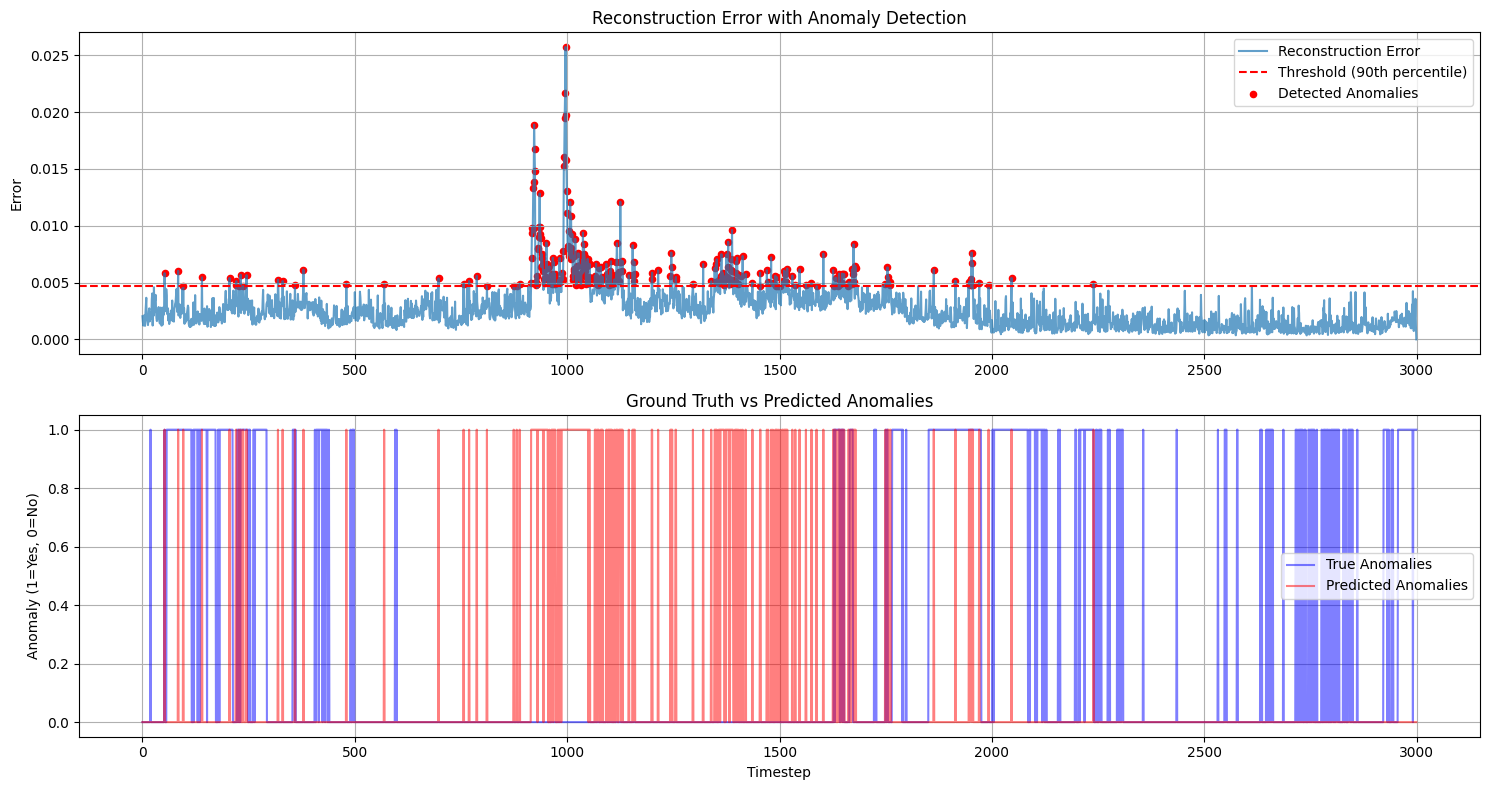

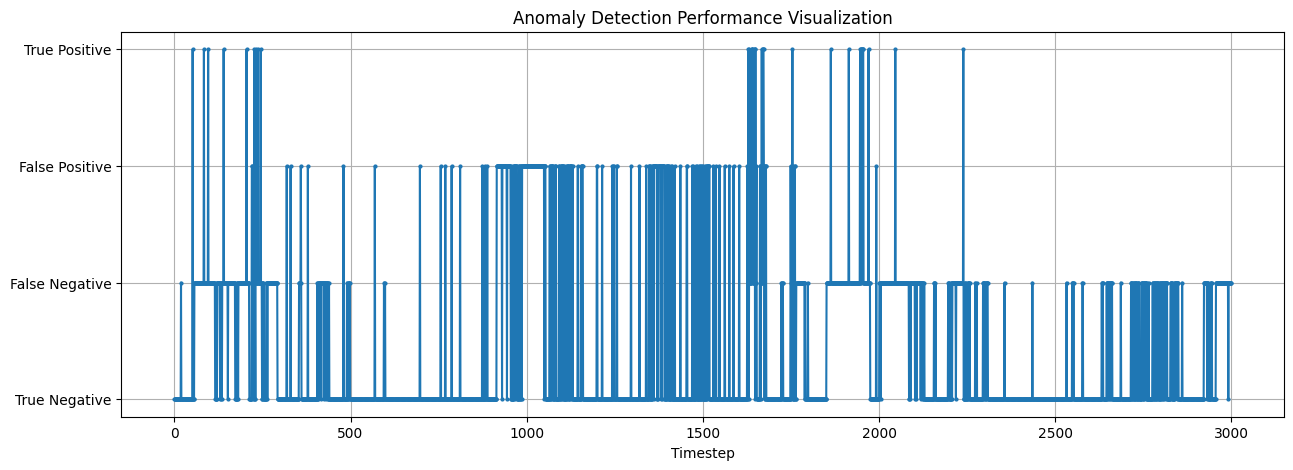

In [3]:
# ========================
# 9. SIMULATION & EVALUATION (Improved)
# ========================


# Make sure test_data and test_labels are properly aligned
test_data = test_data.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Use last 3000 entries for testing
test_data = test_data.tail(3000)
test_labels = test_labels.tail(3000)

# Create sequences for testing
# This creates overlapping sequences for all possible windows in the data
test_sequences = create_ae_sequences(test_data.values, FORECAST_STEPS)
print(f"Created {len(test_sequences)} test sequences of shape {test_sequences.shape}")

# Process all sequences to get reconstruction errors
reconstruction_errors = []
reconstructed_sequences = []

# Process in reasonably sized batches for memory efficiency
batch_size = 128
for i in range(0, len(test_sequences), batch_size):
    batch = test_sequences[i:i+batch_size]
    # Get reconstructions
    reconstructions = lstm_ae.predict(batch, verbose=0)
    # Calculate reconstruction error for each sequence (mean across features and timesteps)
    for j in range(len(batch)):
        original = batch[j]
        reconstructed = reconstructions[j]
        # Store the reconstructed sequence
        reconstructed_sequences.append(reconstructed)
        # Calculate MSE for each timestep across all features
        error_per_timestep = np.mean((original - reconstructed)**2, axis=1)
        reconstruction_errors.append(error_per_timestep)

# Convert to numpy array for easier manipulation
reconstruction_errors = np.array(reconstruction_errors)

# Calculate error scores
# For each original timestep, we have multiple predictions (one from each sequence it appears in)
# We need to aggregate these to get a single error score per original timestep

# Initialize array to hold aggregated errors
timesteps_total = len(test_data) - FORECAST_STEPS + 1  # Number of sequences
aggregated_errors = np.zeros(timesteps_total + FORECAST_STEPS - 1)  # Total timesteps covered
counts = np.zeros(timesteps_total + FORECAST_STEPS - 1)  # Count how many predictions we have for each timestep

# For each sequence
for i in range(len(reconstruction_errors)):
    # For each timestep in the sequence
    for j in range(FORECAST_STEPS):
        # Add error to the corresponding position in the original time series
        aggregated_errors[i + j] += reconstruction_errors[i][j]
        counts[i + j] += 1

# Average the errors where we have multiple predictions
aggregated_errors = np.divide(aggregated_errors, counts, where=counts>0)

# Calculate threshold
threshold = np.percentile(aggregated_errors[counts > 0], THRESHOLD_PERCENTILE)

# Generate anomaly flags
anomaly_flags = (aggregated_errors > threshold).astype(int)

# Align with original labels
# The labels need to be aligned with the outputs of our autoencoder
# Our aggregated_errors array spans from the first timestep to the last possible prediction
# We need to match this with our test_labels
aligned_labels = test_labels.values[:len(anomaly_flags)]

# Make sure both arrays are the same length
min_len = min(len(anomaly_flags), len(aligned_labels))
anomaly_flags = anomaly_flags[:min_len]
aligned_labels = aligned_labels[:min_len]

# Compute classification metrics
precision = precision_score(aligned_labels, anomaly_flags, zero_division=0)
recall = recall_score(aligned_labels, anomaly_flags, zero_division=0)
f1 = f1_score(aligned_labels, anomaly_flags, zero_division=0)

print("\nAnomaly Detection Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix values
true_positives = ((aligned_labels == 1) & (anomaly_flags == 1)).sum()
false_positives = ((aligned_labels == 0) & (anomaly_flags == 1)).sum()
true_negatives = ((aligned_labels == 0) & (anomaly_flags == 0)).sum()
false_negatives = ((aligned_labels == 1) & (anomaly_flags == 0)).sum()

print("\nConfusion Matrix Details:")
print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")
print(f"Total Anomaly Timesteps in Ground Truth: {aligned_labels.sum()}")
print(f"Total Timesteps Flagged as Anomalies: {anomaly_flags.sum()}")

# Plot results
plt.figure(figsize=(15, 8))

# Plot 1: Reconstruction Error and Anomalies
plt.subplot(2, 1, 1)
plt.plot(aggregated_errors, label='Reconstruction Error', alpha=0.7)
plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold ({THRESHOLD_PERCENTILE}th percentile)')
plt.scatter(
    np.where(anomaly_flags == 1)[0], 
    aggregated_errors[anomaly_flags == 1], 
    color='red', 
    label='Detected Anomalies', 
    s=20
)
plt.title('Reconstruction Error with Anomaly Detection')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Plot 2: Comparing with Ground Truth
plt.subplot(2, 1, 2)
plt.plot(aligned_labels, label='True Anomalies', color='blue', alpha=0.5)
plt.plot(anomaly_flags, label='Predicted Anomalies', color='red', alpha=0.5)
plt.title('Ground Truth vs Predicted Anomalies')
plt.xlabel('Timestep')
plt.ylabel('Anomaly (1=Yes, 0=No)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("anomaly_detection_results_improved.png")
plt.show()

# Additional plot to visualize matches and mismatches
plt.figure(figsize=(15, 5))
anomaly_comparison = np.zeros(len(aligned_labels))
anomaly_comparison[(aligned_labels == 1) & (anomaly_flags == 1)] = 3  # True Positives
anomaly_comparison[(aligned_labels == 0) & (anomaly_flags == 1)] = 2  # False Positives
anomaly_comparison[(aligned_labels == 1) & (anomaly_flags == 0)] = 1  # False Negatives
# True Negatives are left as 0

plt.plot(anomaly_comparison, 'o-', markersize=2)
plt.grid(True)
plt.yticks([0, 1, 2, 3], ['True Negative', 'False Negative', 'False Positive', 'True Positive'])
plt.title('Anomaly Detection Performance Visualization')
plt.xlabel('Timestep')
plt.savefig("anomaly_detection_performance.png")
plt.show()

In [4]:
# ========================
# 9. SIMULATION & EVALUATION
# ========================
THRESHOLD_PERCENTILE = 90

test_data = test_data.reset_index(drop=True)

test_labels = test_labels.reset_index(drop=True)


In [5]:

test_data = test_data.tail(3000)

test_labels = test_labels.tail(3000)
simulation_y = create_ae_sequences(test_data.values, FORECAST_STEPS)

In [6]:
# ========================
# 9. SIMULATION & EVALUATION (Per-Timestep Detection)
# ========================

# Initialize lists to store evaluation results
reconstruction_list = []
reconstruction_errors = []
anomaly_flags_list = []

# Loop over windows (each with INPUT_STEPS timesteps)
for i in range(0, len(simulation_y), WINDOW_SIZE_SIMULATION):
    window_data = simulation_y[i]  # shape: (INPUT_STEPS, features)
    
    # Reshape to (1, INPUT_STEPS, features)
    window_X = np.expand_dims(window_data, axis=0)
    
    # Predict reconstruction
    y_reconstructed = lstm_ae.predict(window_X, batch_size=128, verbose=0)[0]
    
    # Reconstruction error per timestep
    reconstruction_error = np.mean((window_data - y_reconstructed)**2, axis=1)  # shape: (INPUT_STEPS,)
    
    # Store reconstructions and errors
    reconstruction_list.append(y_reconstructed)
    reconstruction_errors.extend(reconstruction_error)


In [7]:
THRESHOLD_PERCENTILE = 90
# Compute global threshold
all_errors = np.hstack(reconstruction_errors)
threshold = np.percentile(all_errors, THRESHOLD_PERCENTILE)

# reconstruction_errors is a list of arrays (each of shape [INPUT_STEPS])
#anomaly_flags_list = [((err > threshold).astype(int)).tolist() for err in reconstruction_errors]
#anomaly_flags_list = [item for sublist in anomaly_flags_list for item in sublist]  # Flatten

# reconstruction_errors is already a flat list of floats (one per timestep)
anomaly_flags_list = [(err > threshold) for err in reconstruction_errors]
anomaly_flags_list = np.array(anomaly_flags_list, dtype=int)


In [8]:
anomaly_flags_list.shape

(2990,)

In [9]:
# ========== Anomaly Detection Metrics (Timestep-wise) ==========
total_flags = np.array(anomaly_flags_list, dtype=int)

# Align labels: skip the first FORECAST_STEPS to match start of sequences
total_labels = test_labels[FORECAST_STEPS:FORECAST_STEPS + len(total_flags)].reset_index(drop=True).values

# Ensure both arrays match in length
min_len = min(len(total_flags), len(total_labels))
total_flags = total_flags[:min_len]
total_labels = total_labels[:min_len]

# Compute classification metrics
precision = precision_score(total_labels, total_flags, zero_division=0)
recall = recall_score(total_labels, total_flags, zero_division=0)
f1 = f1_score(total_labels, total_flags, zero_division=0)

# Print results
print("\nAnomaly Detection Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Anomaly Detection Precision: 0.08695652173913043
Recall: 0.03494623655913978
F1 Score: 0.04985618408437201


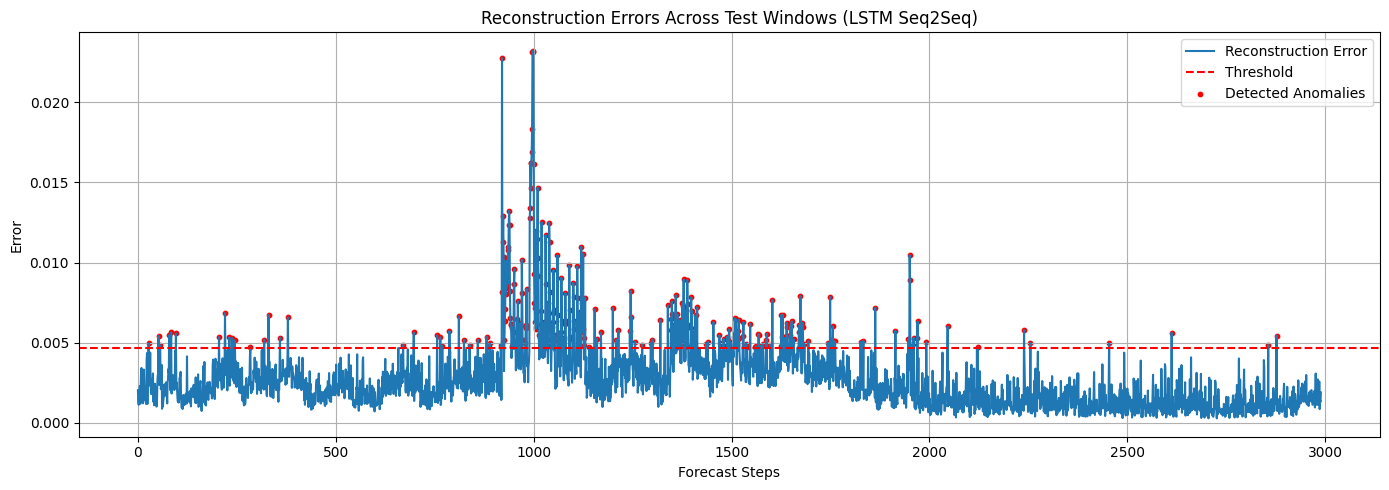

In [10]:

# ========================
# 12. PLOTS
# ========================

# Create a figure for reconstruction error visualization
plt.figure(figsize=(14,5))

# Flatten reconstruction errors across all windows
all_errors = np.hstack(reconstruction_errors)

# Plot reconstruction errors
plt.plot(all_errors, label='Reconstruction Error')

# Plot anomaly detection threshold line
plt.axhline(np.percentile(all_errors, THRESHOLD_PERCENTILE), color='red', linestyle='--', label='Threshold')

# Highlight detected anomalies with red dots
plt.scatter(
    np.where(all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)), 
    all_errors[all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)], 
    color='red', 
    label='Detected Anomalies', 
    s=10
)

# Title and labels
plt.title("Reconstruction Errors Across Test Windows (LSTM Seq2Seq)")
plt.xlabel("Forecast Steps")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and show the plot
plt.savefig("reconstruction_errors_lstm_seq2seq.png")
plt.show()
